# Installing dependencies

In [1]:
!pip install nltk

In [2]:
!pip install transformers

# Load all dependencies

In [3]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch
import csv


/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


# Load and preprocess the dataset

In [4]:
df = pd.read_csv('/content/Reviews.csv', encoding='utf-8',quoting=csv.QUOTE_NONE,  on_bad_lines='skip')
df.head()


,Id,ProductId,UserId,Rating,Summary,Review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,"""Product arrived labeled as Jumbo Salted Peanu..."
2,4,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine,If you are looking for the secret ingredient i...
3,9,B000E7L2R4,A1MZYO9TZK0BBI,5,Yay Barley,Right now I'm mostly just sprouting this so my...
4,10,B00171APVA,A21BT40VZCCYT4,5,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [5]:
#checking for columnds and their dtype
df.info()
#checking for null value
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192540 entries, 0 to 192539
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         192540 non-null  int64 
 1   ProductId  192540 non-null  object
 2   UserId     192540 non-null  object
 3   Rating     192540 non-null  int64 
 4   Summary    192538 non-null  object
 5   Review     192537 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.8+ MB


,0
Id,0
ProductId,0
UserId,0
Rating,0
Summary,2
Review,3


In [6]:
df['Summary'].fillna('No Summary', inplace=True)
df['Review'].fillna('No Review', inplace=True)

In [7]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
Rating,0
Summary,0
Review,0


In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
#define the function to clean and tokenize text
def clean_and_tokenize(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize text
    tokens = word_tokenize(text)
    return tokens



In [10]:
# Apply cleaning and tokenization to the Summary and Review columns
df['Summary_Tokens'] = df['Summary'].apply(clean_and_tokenize)
df['Review_Tokens'] = df['Review'].apply(clean_and_tokenize)

# Display the updated DataFrame to verify changes
df[['Summary', 'Summary_Tokens', 'Review', 'Review_Tokens']].head()
print(df)


            Id   ProductId          UserId  Rating  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW       5   
1            2  B00813GRG4  A1D87F6ZCVE5NK       1   
2            4  B000UA0QIQ  A395BORC6FGVXV       2   
3            9  B000E7L2R4  A1MZYO9TZK0BBI       5   
4           10  B00171APVA  A21BT40VZCCYT4       5   
...        ...         ...             ...     ...   
192535  568450  B001EO7N10  A28KG5XORO54AY       5   
192536  568451  B003S1WTCU  A3I8AFVPEE8KI5       2   
192537  568452  B004I613EE  A121AA1GQV751Z       5   
192538  568453  B004I613EE   A3IBEVCTXKNOH       5   
192539  568454  B001LR2CU2  A3LGQPJCZVL9UC       5   

                                   Summary  \
0                    Good Quality Dog Food   
1                        Not as Advertised   
2                           Cough Medicine   
3                               Yay Barley   
4                         Healthy Dog Food   
...                                    ...   
192535                 Will n

# Feature eng

In [11]:
# Flatten the tokenized text for TF-IDF vectorization
df['Summary_Joined'] = df['Summary_Tokens'].apply(lambda x: ' '.join(x))
df['Review_Joined'] = df['Review_Tokens'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF to Summary and Review
tfidf_summary = tfidf_vectorizer.fit_transform(df['Summary_Joined'])
tfidf_review = tfidf_vectorizer.fit_transform(df['Review_Joined'])

# Display the shape of the resulting TF-IDF matrices
tfidf_summary.shape, tfidf_review.shape


((192540, 20979), (192540, 75716))

# Model Development

# User and Item Embeddings:

In [12]:
# Group reviews by UserId to create user profiles
user_reviews = df.groupby('UserId')['Review_Joined'].agg(lambda x: ' '.join(x)).reset_index()

# Group reviews by ProductId to create item profiles
item_descriptions = df.groupby('ProductId')['Review_Joined'].agg(lambda x: ' '.join(x)).reset_index()


In [13]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load pre-trained TinyBERT model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = BertModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

def get_tinybert_embeddings(texts, batch_size=32):  # Adapt batch size based on GPU memory
    batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
    all_embeddings = []

    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(batches):
            inputs = tokenizer(batch, return_tensors="pt", max_length=64, truncation=True, padding='max_length')
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(1).cpu().numpy()
            all_embeddings.append(embeddings)

            print(f"Processed batch {i+1}/{len(batches)}")

    all_embeddings = np.vstack(all_embeddings)
    return all_embeddings


def generate_embeddings(text_list):
    if isinstance(text_list, list) and all(isinstance(text, str) for text in text_list):
        embeddings = []
        chunk_size = 1000  # Process in chunks to avoid memory overflow
        for i in range(0, len(text_list), chunk_size):
            print(f"Processing chunk {i//chunk_size + 1} of {len(text_list)//chunk_size + 1}")
            chunk_embeddings = get_tinybert_embeddings(text_list[i:i + chunk_size], batch_size=32)
            embeddings.append(chunk_embeddings)
        return np.vstack(embeddings)
    else:
        raise ValueError("Input must be a list of strings.")

# Generate embeddings for user reviews and item descriptions
user_embeddings = generate_embeddings(user_reviews['Review_Joined'].tolist())
item_embeddings = generate_embeddings(item_descriptions['Review_Joined'].tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Processed batch 30/32
Processed batch 31/32
Processed batch 32/32
Processing chunk 8 of 114
Processed batch 1/32
Processed batch 2/32
Processed batch 3/32
Processed batch 4/32
Processed batch 5/32
Processed batch 6/32
Processed batch 7/32
Processed batch 8/32
Processed batch 9/32
Processed batch 10/32
Processed batch 11/32
Processed batch 12/32
Processed batch 13/32
Processed batch 14/32
Processed batch 15/32
Processed batch 16/32
Processed batch 17/32
Processed batch 18/32
Processed batch 19/32
Processed batch 20/32
Processed batch 21/32
Processed batch 22/32
Processed batch 23/32
Processed batch 24/32
Processed batch 25/32
Processed batch 26/32
Processed batch 27/32
Processed batch 28/32
Processed batch 29/32
Processed batch 30/32
Processed batch 31/32
Processed batch 32/32
Processing chunk 9 of 114
Processed batch 1/32
Processed batch 2/32
Processed batch 3/32
Processed batch 4/32
Processed batch 5/32
Processed batch 6/32
Processed 

# Context-Aware Recommendations:

In [14]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set the EOS token as the padding token if the tokenizer does not have one
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def generate_gpt_recommendations(user_history, top_k=5, max_length=1024, max_new_tokens=50):
    """
    Generate recommendations using GPT based on user interaction history.
    """
    # Prepare the input for GPT
    gpt_input = f"User has interacted with: {user_history}. Recommend top {top_k} items."

    # Tokenize input, ensuring padding and attention mask are used
    inputs = tokenizer(gpt_input, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    attention_mask = inputs['attention_mask']  # Ensure attention mask is created

    # Generate output with attention mask and a limit on the number of new tokens
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=attention_mask,
        pad_token_id=tokenizer.pad_token_id,  # Use the pad token ID set earlier
        max_new_tokens=max_new_tokens
    )

    # Decode the output to get the recommendations
    recommendations = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Post-process the recommendations
    recommended_items = recommendations.split(',')[:top_k]
    return [item.strip() for item in recommended_items]

# Example usage
user_history_example = "Purchased dog food, cat litter, and various pet supplies."
recommendations = generate_gpt_recommendations(user_history_example)
print(recommendations)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

['User has interacted with: Purchased dog food', 'cat litter', 'and various pet supplies.. Recommend top 5 items.\n\nRated 5 out of 5 by Anonymous from Great product! I bought this product for my dog and he loves it. He loves it and I love it. I have a dog that is very small and very shy. He loves it and I']


# Hybrid model

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def combine_bert_gpt_recommendations(user_embedding, item_embeddings, gpt_recommendations, item_ids, top_k=5):
    """
    Combine BERT-based embeddings with GPT recommendations to produce a final ranking.

    Parameters:
    - user_embedding: The BERT-based embedding for the user.
    - item_embeddings: A matrix of BERT-based embeddings for all items.
    - gpt_recommendations: A list of items recommended by GPT.
    - item_ids: A list of item IDs corresponding to the embeddings.
    - top_k: The number of top recommendations to return.

    Returns:
    - List of top recommended item IDs.
    """
    # Calculate cosine similarity between user embedding and item embeddings
    similarities = cosine_similarity(user_embedding.reshape(1, -1), item_embeddings).flatten()

    # Create a dictionary to map item IDs to their similarity scores
    item_scores = {item_ids[i]: similarities[i] for i in range(len(item_ids))}

    # Boost scores of items recommended by GPT
    for item in gpt_recommendations:
        if item in item_scores:
            item_scores[item] += 0.1  # Arbitrary boost, can be tuned

    # Sort items by score
    ranked_items = sorted(item_scores, key=item_scores.get, reverse=True)

    # Return top-k items
    return ranked_items[:top_k]


In [16]:
# Assuming df has a column 'UserId' and that user_embeddings are aligned with unique user IDs
user_id_to_index = {user_id: idx for idx, user_id in enumerate(df['UserId'].unique())}

def get_sample_recommendations(user_id, user_embeddings, item_embeddings, df, item_ids, top_k=5):
    """
    Generate sample recommendations for a user by combining BERT and GPT outputs.

    Parameters:
    - user_id: The alphanumeric ID of the user to generate recommendations for.
    - user_embeddings: A matrix of BERT-based embeddings for all users.
    - item_embeddings: A matrix of BERT-based embeddings for all items.
    - df: The DataFrame containing user data and interaction history.
    - item_ids: A list of item IDs corresponding to the embeddings.
    - top_k: The number of top recommendations to return.

    Returns:
    - List of recommended item IDs.
    """
    # Ensure user_id exists in the mapping
    if user_id not in user_id_to_index:
        print(f"Invalid user_id: {user_id}")
        return []

    # Get user index from the mapping
    user_index = user_id_to_index[user_id]

    # Get user embedding and history
    user_embedding = user_embeddings[user_index].reshape(1, -1)

    # Handle case where user has no history
    user_data = df[df['UserId'] == user_id]
    if 'Review_Joined' not in df.columns or user_data['Review_Joined'].values.size == 0:
        print(f"No review history found for User ID: {user_id}")
        return []

    user_history = user_data['Review_Joined'].values[0]

    # Generate GPT recommendations
    gpt_recommendations = generate_gpt_recommendations(user_history, top_k)

    # Combine BERT and GPT recommendations
    final_recommendations = combine_bert_gpt_recommendations(
        user_embedding, item_embeddings, gpt_recommendations, item_ids, top_k
    )

    return final_recommendations

# Clean the column names
df.columns = df.columns.str.strip()

# Assuming your DataFrame has a column 'ProductId' corresponding to the items
item_ids = df['ProductId'].unique().tolist()

# Example to test
sample_recommendations = get_sample_recommendations(
    user_id='A3SGXH7AUHU8GW',  # Example alphanumeric user ID
    user_embeddings=user_embeddings,
    item_embeddings=item_embeddings,
    df=df,
    item_ids=item_ids,
    top_k=5
)

print(f"Sample Recommendations for User A3SGXH7AUHU8GW: {sample_recommendations}")


Sample Recommendations for User A3SGXH7AUHU8GW: ['B001BZEGN0', 'B001EO6866', 'B0000CNU1A', 'B000FYXBPW', 'B001IEXQSU']


In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_recommendations(true_labels, predictions):
    """
    Evaluate the quality of the recommendation system.

    Parameters:
    - true_labels: List of sets, where each set contains the actual items that are relevant to the user.
    - predictions: List of lists, where each list contains recommended items for the user.

    Returns:
    - Precision, Recall, and F1 score of the recommendations.
    """
    precisions, recalls, f1_scores = [], [], []

    # Evaluate each set of recommendations
    for true_items, predicted_items in zip(true_labels, predictions):
        # Convert predictions to binary labels
        predicted_labels = [1 if item in predicted_items else 0 for item in true_items]
        true_labels = [1] * len(predicted_labels)  # True items are relevant

        # Calculate precision, recall, and F1 score
        precision = precision_score(true_labels, predicted_labels, zero_division=0)
        recall = recall_score(true_labels, predicted_labels, zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, zero_division=0)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Return the average scores
    return np.mean(precisions), np.mean(recalls), np.mean(f1_scores)

# Example usage
true_items = [{'item1', 'item2', 'item3'}, {'item4', 'item5'}]
predicted_items = [['item2', 'item3', 'item6'], ['item5', 'item7']]

precision, recall, f1 = evaluate_recommendations(true_items, predicted_items)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")


Precision: 1.000, Recall: 0.583, F1 Score: 0.733


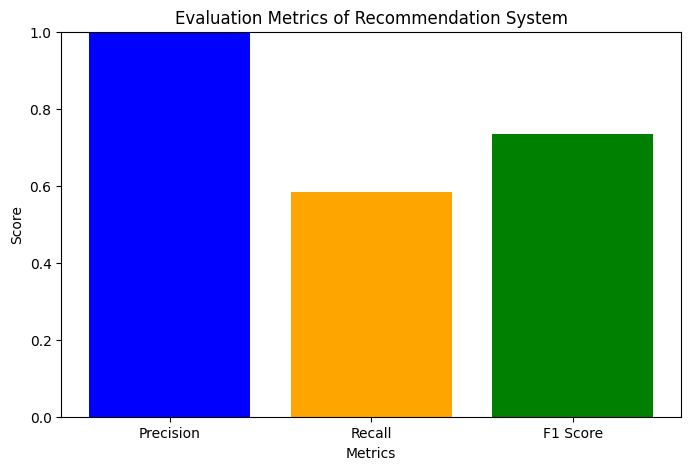

In [18]:
import matplotlib.pyplot as plt

def plot_evaluation_metrics(precision, recall, f1):
    """
    Plot the Precision, Recall, and F1 score as a bar chart.

    Parameters:
    - precision: Precision score
    - recall: Recall score
    - f1: F1 score
    """
    # Metrics and their values
    metrics = ['Precision', 'Recall', 'F1 Score']
    scores = [precision, recall, f1]

    # Create the bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, scores, color=['blue', 'orange', 'green'])
    plt.ylim(0, 1)  # Precision, Recall, and F1 score range between 0 and 1
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics of Recommendation System')
    plt.show()

# Example usage with the calculated metrics
plot_evaluation_metrics(precision, recall, f1)
